In [1]:
# Import necessary libraries
import os
import numpy as np
from keras.applications.efficientnet import EfficientNetB7, preprocess_input
from keras.preprocessing import image
import tensorflow as tf
import seaborn as sns
from keras.preprocessing import image
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras import layers
import torch
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Data directories
train_dir = '/content/drive/MyDrive/DR_50_70/Train_70'
test_dir = '/content/drive/MyDrive/DR_50_70/Test_70'

Mounted at /content/drive


In [3]:
# Load model for feature extraction
model = EfficientNetB7(weights='imagenet', include_top=False)

258076736/258076736 [==============================] - 2s 0us/step


In [4]:
# Function to extract features from an image
def extract_features_B7net(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = model.predict(img_data)
    return features

In [5]:
#load image and extract features
import os

x_train, y_train = [], []
for i in range(5):
    class_dir = os.path.join(train_dir, str(i))
    for img_path in os.listdir(class_dir):
        features = extract_features_B7net(os.path.join(class_dir, img_path))
        x_train.append(features)
        y_train.append(i)

1/1 [==============================] - 1s 720ms/step


In [6]:

# Load images and extract features
x_test, y_test = [], []
for i in range(5):
    class_dir = os.path.join(test_dir, str(i))
    for img_path in os.listdir(class_dir):
        features = extract_features_B7net(os.path.join(class_dir, img_path))
        x_test.append(features)
        y_test.append(i)

1/1 [==============================] - 0s 448ms/step


Training Decision Tree (gini)...
True Positives: 439
True Negatives: 2464
False Positives: 236
False Negatives: 236
Accuracy: 0.8601481481481481
Precision: 0.6535748281308998
Specificity: 0.9125925925925926
Sensitivity: 0.6503703703703704
F1 Score: 0.6511710320175116
Recall: 0.6503703703703704



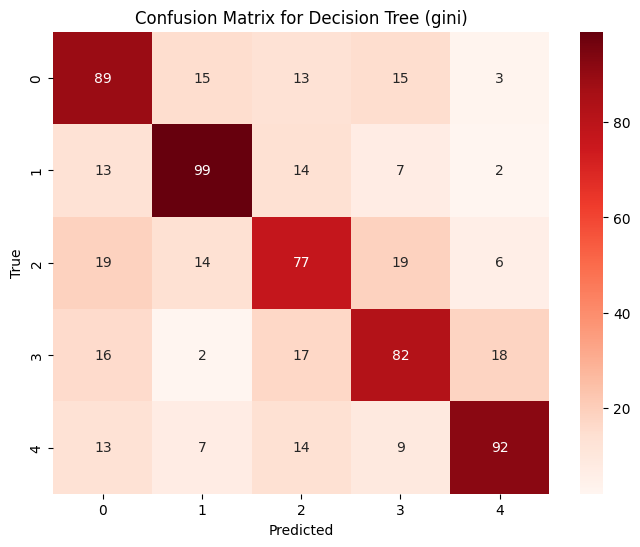

Training Decision Tree (entropy)...
True Positives: 450
True Negatives: 2475
False Positives: 225
False Negatives: 225
Accuracy: 0.8666666666666667
Precision: 0.670337315341139
Specificity: 0.9166666666666666
Sensitivity: 0.6666666666666666
F1 Score: 0.6676716182133857
Recall: 0.6666666666666666



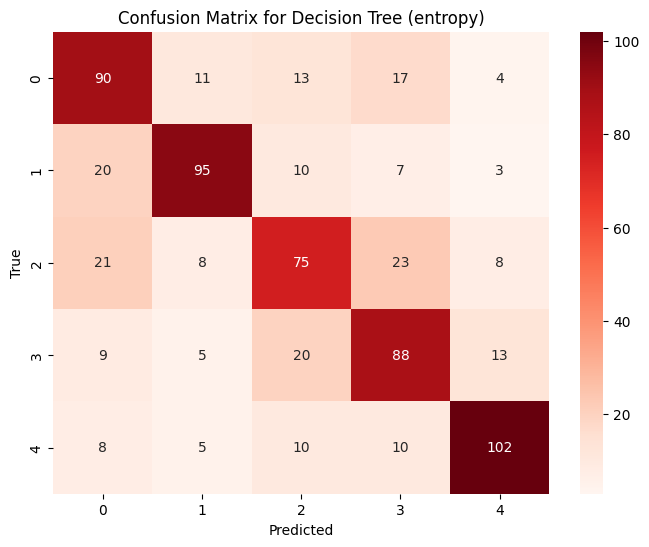

Training Extra Trees...
True Positives: 586
True Negatives: 2611
False Positives: 89
False Negatives: 89
Accuracy: 0.9472592592592592
Precision: 0.8777918115642287
Specificity: 0.967037037037037
Sensitivity: 0.8681481481481482
F1 Score: 0.8697268872949453
Recall: 0.8681481481481482



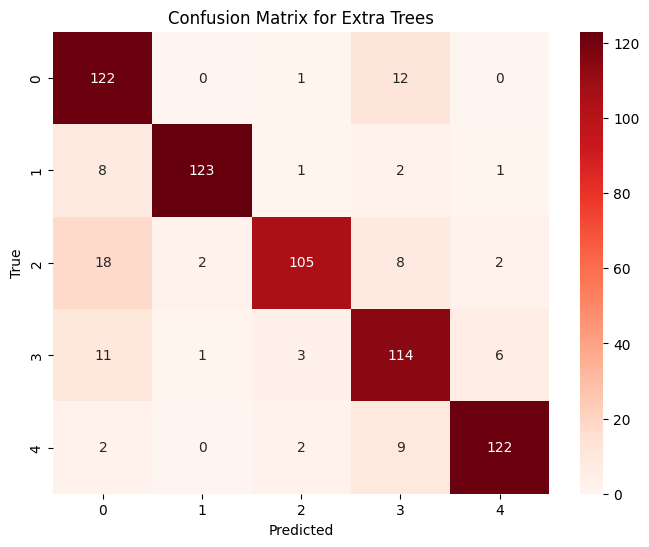

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# List of classifiers to try
classifiers = [
    DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1),
    DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1),
    ExtraTreesClassifier(n_estimators=100)
]

classifier_names = [
    'Decision Tree (gini)',
    'Decision Tree (entropy)',
    'Extra Trees'
]

x_train_flat = np.array([feature.flatten() for feature in x_train])
x_test_flat = np.array([feature.flatten() for feature in x_test])

for clf, name in zip(classifiers, classifier_names):
    print(f"\033[1mTraining {name}...\033[0m")

    # Train classifier
    clf.fit(x_train_flat, y_train)

    # Predict on test set
    y_pred = clf.predict(x_test_flat)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Compute TP, TN, FP, FN for each class
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    num_classes = cm.shape[0]
    TN = []
    for i in range(num_classes):
        temp = np.delete(cm, i, 0)   # delete ith row
        temp = np.delete(temp, i, 1)  # delete ith column
        TN.append(sum(sum(temp)))

    # Compute overall TP, TN, FP, FN
    overall_TP = np.sum(TP)
    overall_TN = np.sum(TN)
    overall_FP = np.sum(FP)
    overall_FN = np.sum(FN)

    # Compute accuracy, precision, specificity, sensitivity, F1-score, recall
    accuracy = (overall_TP + overall_TN) / (overall_TP + overall_TN + overall_FP + overall_FN)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    specificity = overall_TN / (overall_TN + overall_FP)

    # Print performance metrics
    print(f'True Positives: {overall_TP}')
    print(f'True Negatives: {overall_TN}')
    print(f'False Positives: {overall_FP}')
    print(f'False Negatives: {overall_FN}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Specificity: {specificity}')
    print(f'Sensitivity: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Recall: {recall}\n')

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
